# Data Ingestion



In [2]:
import os, os.path
import pandas as pd
import numpy as np

## Sylvia's

In [3]:
folders = [folder for folder in os.listdir('./logs-sylvia') if folder != '.DS_Store']
dfs = [None]*len(folders)


for i,folder in enumerate(folders):
    filename = f"./logs-sylvia/{folder}/data.csv"
    dfs[i] = pd.read_csv(filename,usecols=['time','pot','c_lvl_lo','c_lvl_hi','t_lvl_lo','t_lvl_hi','rain_count'],index_col='time',parse_dates=True)
    
df = pd.concat(dfs).sort_index()

df.to_csv('p2-sylvia-clean.csv')

## Quitelpec

In [12]:
folders = [folder for folder in os.listdir('./logs-quitelpec') if folder != '.DS_Store']
dfs = [None]*len(folders)


for i,folder in enumerate(folders):
    filename = f"./logs-quitelpec/{folder}/data.csv"
    dfs[i] = pd.read_csv(filename,index_col='time',parse_dates=True)

    
df = pd.concat(dfs).sort_index()

# df = df.astype(
#     {
#         "node": str,
#         "parent": str,
#         "POT": np.uint16,
#         "level1": np.uint8,
#         "level2": np.uint8
#     }
# )

# print(df['node'].unique())

node_cistern2_lupe = df.loc[df['node'] == '67A3']
node_rg_lupe = df.loc[df['node'] == '5AA']
node_cistern1_lupe = df.loc[df['node'] == '6838']
node_tlq_lupe = df.loc[df['node'] == '2C3E']
node_cistern_elena = df.loc[df['node'] == '488A']
node_rg_elena = df.loc[df['node'] == '1438']
node_forwarder = df.loc[df['node'] == '601A']

### Source for Node Mapping:

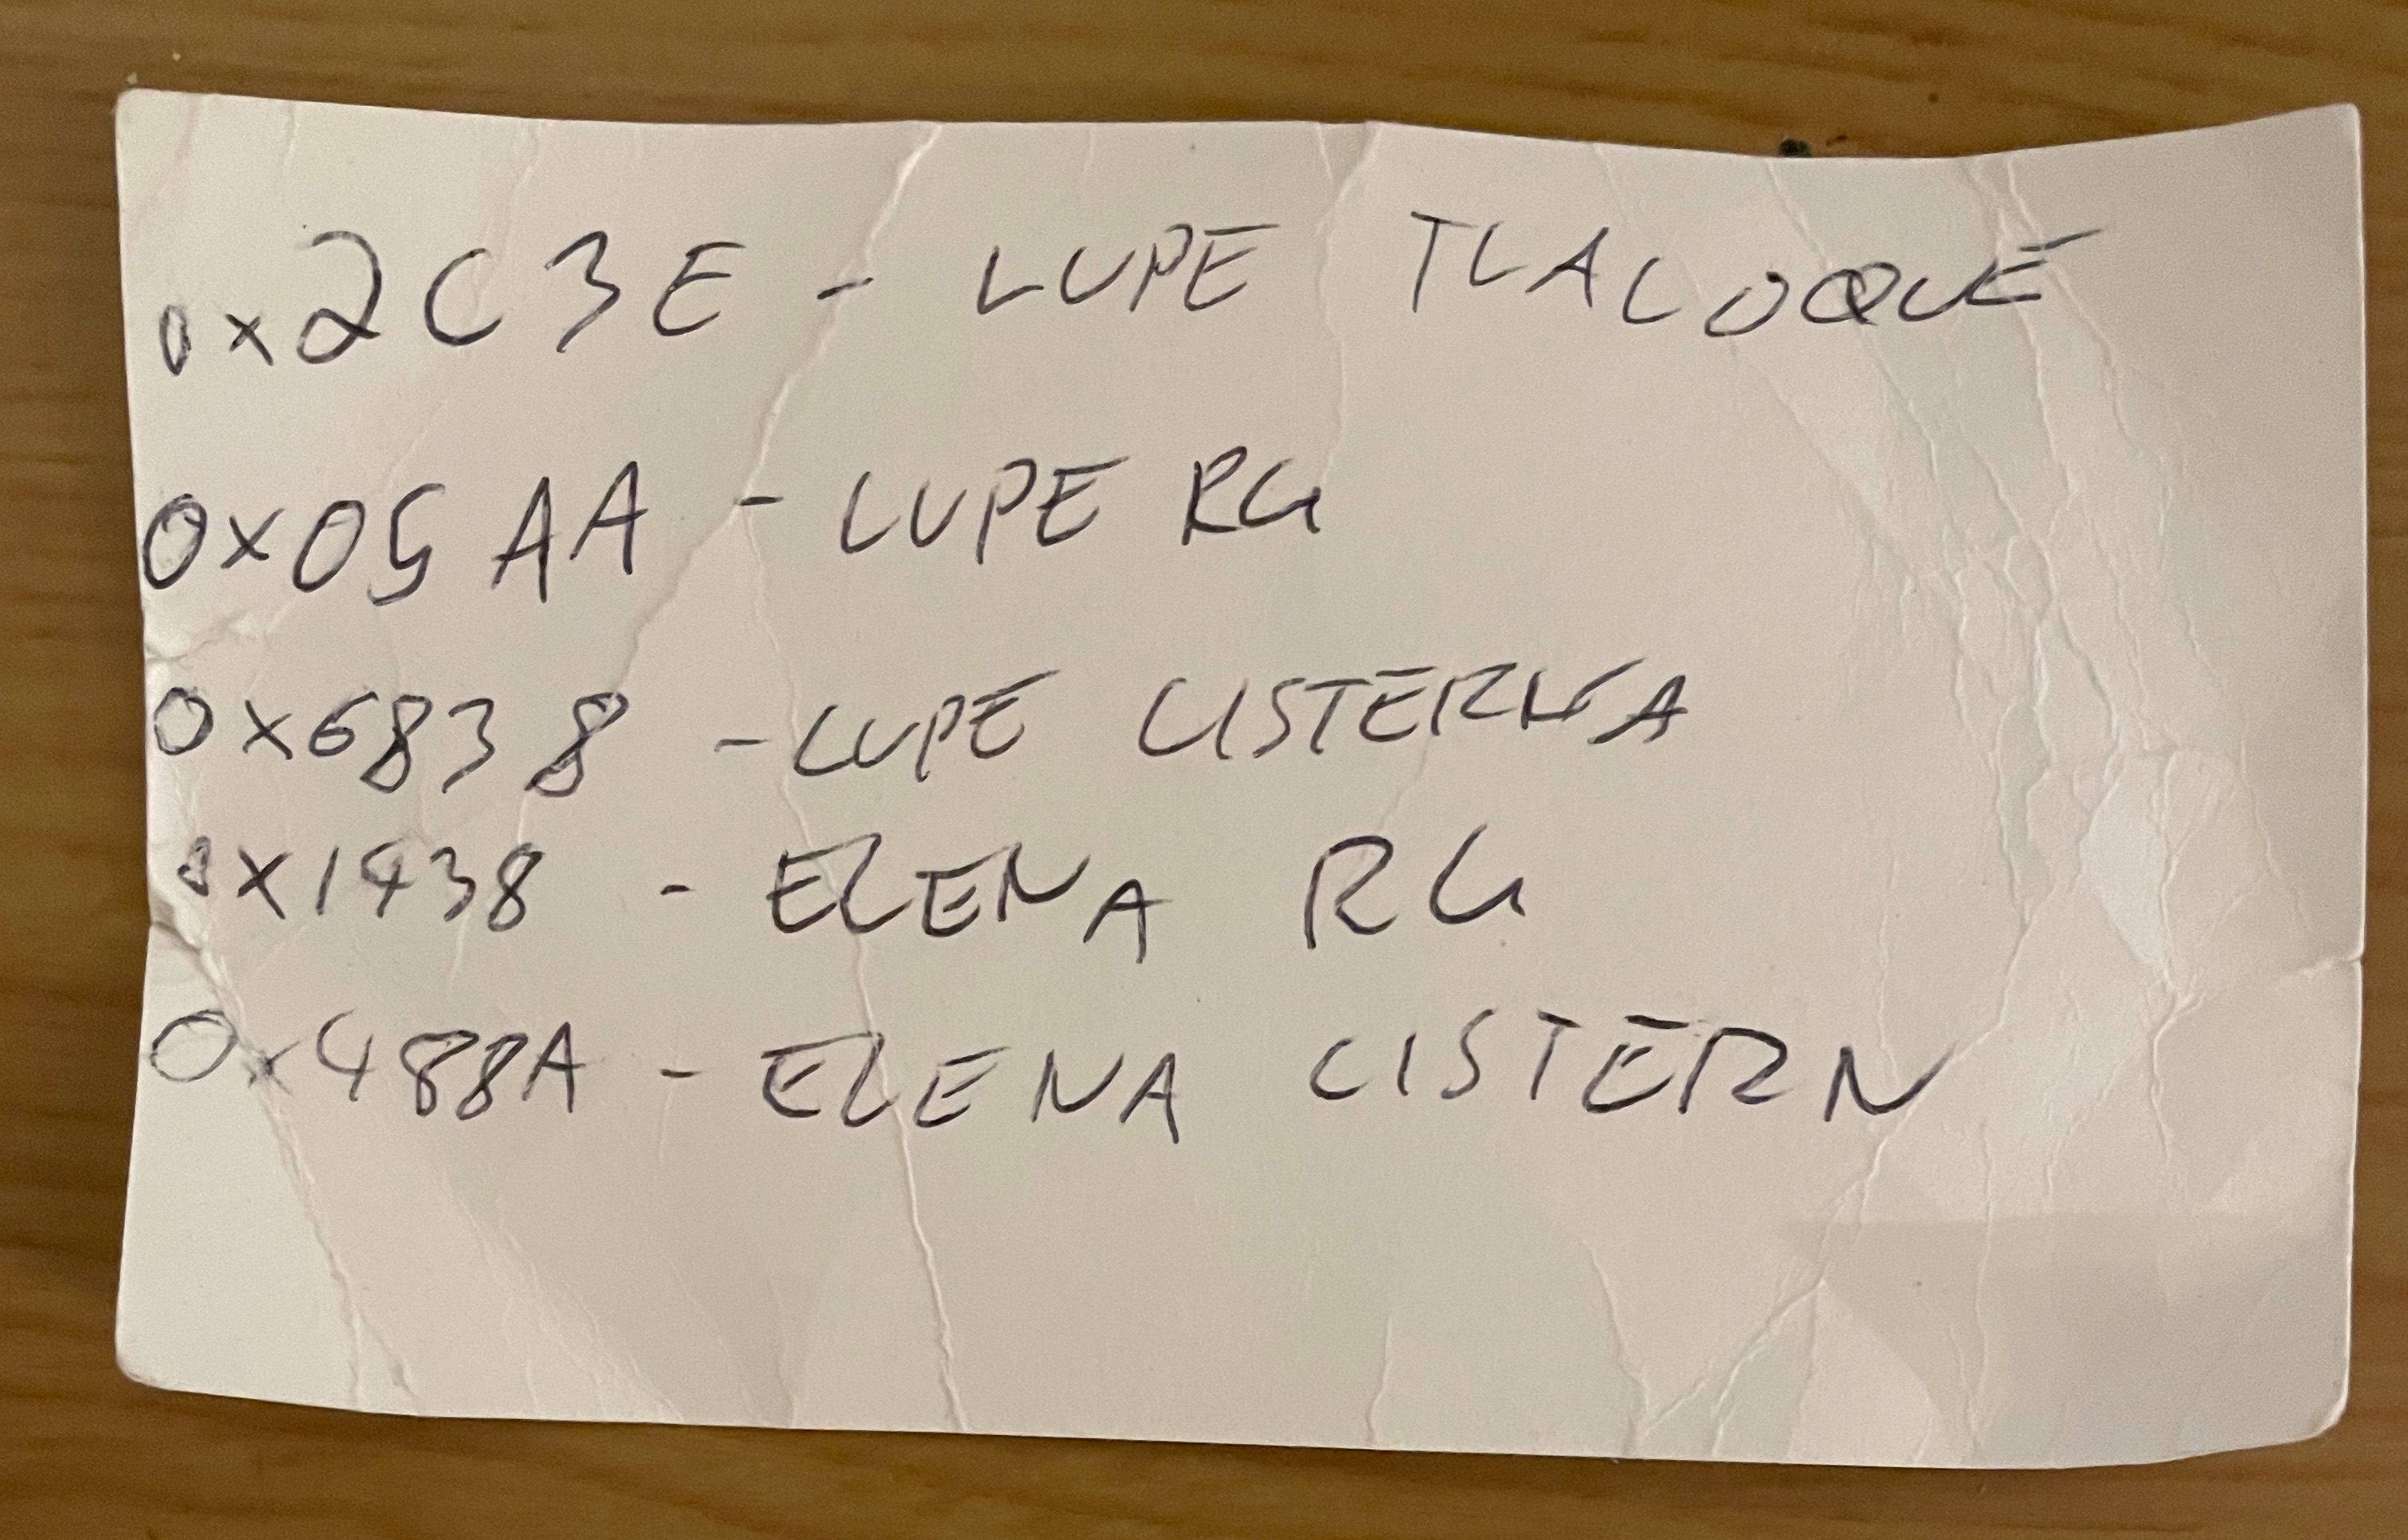

# Cleanup

- Potentiometer value needs to be mapped 
- Raw (binary) level values need to be converted to 'active' value, then combined to get **tank level**
- Bucket count values (if present) need to be converted to mm

## Binary Level Values

First, mapping arbitrary labels to specific labels using same naming convention as Star nodes:

| Silkscreen Pin Name | Arduino Pin # | Label |
|-|-|-|
| PC0 | D14/A0 | pot |
| PC1 | D15/A1 | level1 |
| PC2 | D16/A2 | level2 |



In [14]:
def convert_pot_to_binary (pot_value): # One binary level sensor was mistakenly connected to analog input
    return round(pot_value/512)

node_cistern_elena['pot'] = node_cistern_elena['POT']
node_rg_elena['bucket_counts'] = node_rg_elena['POT']
node_rg_elena['bucket_mm'] = node_rg_elena['bucket_counts'] * 0.38


# Don't know from which raw value the high/low sensor values need to be derived. Raw values are not consistent with expectations...
# node_cistern_elena['c_lvl_hi'] = node_cistern_elena.apply(lambda df: ~(df.level_____) & 1, axis=1).astype(np.uint8)
# node_cistern_elena['c_lvl_lo'] = node_cistern_elena.level_____


/var/folders/1v/vpz9zltd6k1319dwhgj1hcfw0000gp/T/ipykernel_93419/756463396.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_cistern_elena['pot'] = node_cistern_elena['POT']
/var/folders/1v/vpz9zltd6k1319dwhgj1hcfw0000gp/T/ipykernel_93419/756463396.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_rg_elena['bucket_counts'] = node_rg_elena['POT']
/var/folders/1v/vpz9zltd6k1319dwhgj1hcfw0000gp/T/ipykernel_93419/756463396.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Resampling by the hour and exporting:

In [16]:
elena_cistern_level = node_cistern_elena['pot'].resample('1h').mean()
elena_rain_mm = node_rg_elena['bucket_mm'].resample('1h').sum()

elena_cistern_level.to_csv('p2-elena-cistern-level.csv')
elena_rain_mm.to_csv('p2-elena-rain.csv')

Function to convert raw float levels to tank levels:

In [ ]:
def tank_level(float_high, float_low):
    # float_high | float_low | tank_level
    #     0      |     0     |    N/A
    #     0      |     1     |     2
    #     1      |     0     |     0
    #     1      |     1     |     1

    tank_level = None  # 0 == empty, 1 == filling, 2 == full
    tank_code = (int(float_high) << 1) | int(float_low)

    if tank_code == 1:
        tank_level = 2
    elif tank_code == 2:
        tank_level = 0
    elif tank_code == 3:
        tank_level = 1

    return tank_level

In [ ]:
# Not particularly relevant:
node_tlq_lupe['t_lvl_hi'] = node_tlq_lupe.apply(lambda df: convert_pot_to_binary(df.POT), axis=1).astype(np.uint8)
node_tlq_lupe['t_lvl_lo'] = node_tlq_lupe.apply(lambda df: ~(df.level1) & 1, axis=1).astype(np.uint8)

node_cistern1_lupe['pot'] = node_cistern1_lupe['POT']
node_cistern1_lupe['t_lvl_hi'] = node_tlq_lupe.apply(lambda df: convert_pot_to_level(df.POT), axis=1).astype(np.uint8)
node_cistern1_lupe['t_lvl_lo'] = node_tlq_lupe.apply(lambda df: ~(df.level1) & 1, axis=1).astype(np.uint8)
